# Imports and Packages

In [1]:
import os
import re
import csv
import nltk
import gensim
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn import preprocessing
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from skmultilearn.adapt import MLkNN
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import hamming_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#nltk.download('stopwords')

# Functions

In [2]:
#Stop words removal function
stop_words = set(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


#snowball stemming function
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemmedSentence = ""
    for word in sentence.split():
        stemmedword = stemmer.stem(word)
        stemmedSentence += stemmedword
        stemmedSentence += " "
    stemmedSentence = stemmedSentence.strip()
    return stemmedSentence

# Overall Cleaning Function
def cleaner(df, comments_column_name):
    current_df = pd.DataFrame(df)
    current_df[comments_column_name] = current_df[comments_column_name].str.lower()
    current_df[comments_column_name] = current_df[comments_column_name].str.replace('[^\w\s]','')  
    current_df[comments_column_name] = current_df[comments_column_name].replace('\n',' ', regex = True)
    current_df[comments_column_name] = current_df[comments_column_name].apply(removeStopWords)
    current_df[comments_column_name] = current_df[comments_column_name].apply(stemming)
    return current_df

def training_model(alltext, dim, w2v_model):
    training_vecs, missing, missing_texts = embeddings(alltext, dim, w2v_model)
    train_data, val_data, train_cats, val_cats = train_test_split(train_vectors, train_labels)
    lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced',max_iter = 3000)).fit(train_data, train_cats)
    y_vals = np.array(val_cats)
    y_preds = np.transpose(np.array(lr.predict_proba(val_data))[:,:,1])
    aucs = []
    for col in range(y_vals.shape[1]):
        aucs.append(roc_auc_score(y_vals[:,col],y_preds[:,col]))
    mean_auc = np.mean(aucs) # average auc score from all labels
    return mean_auc, lr

def embeddings(alltext, dim, w2v_model):
    zeros = np.zeros(dim) # CREATE 100 DIM ARRAY OF 0s
    features = []
    missing = set()
    missing_texts = set()
    for text in alltext:
        text_feat = zeros
        text_count = 0
        for word in text:
            if word in w2v_model.wv:
                text_feat += w2v_model.wv[word] # add all word embeddings for words in text
                text_count += 1
            else:
                missing.add(word)
        if text_count == 0: # no words are found in text
            features.append(text_feat)
            missing_texts.add(''.join(text))
        else:
            features.append(text_feat/text_count)
    return features, missing, missing_texts

# Data Initiation and Data Visualization Pre-Cleaning

In [3]:
train = pd.read_csv("train.csv")

print("Number of rows in data = ", train.shape[0])
print("Number of columns in data = ", train.shape[1])

Number of rows in data =  159571
Number of columns in data =  8


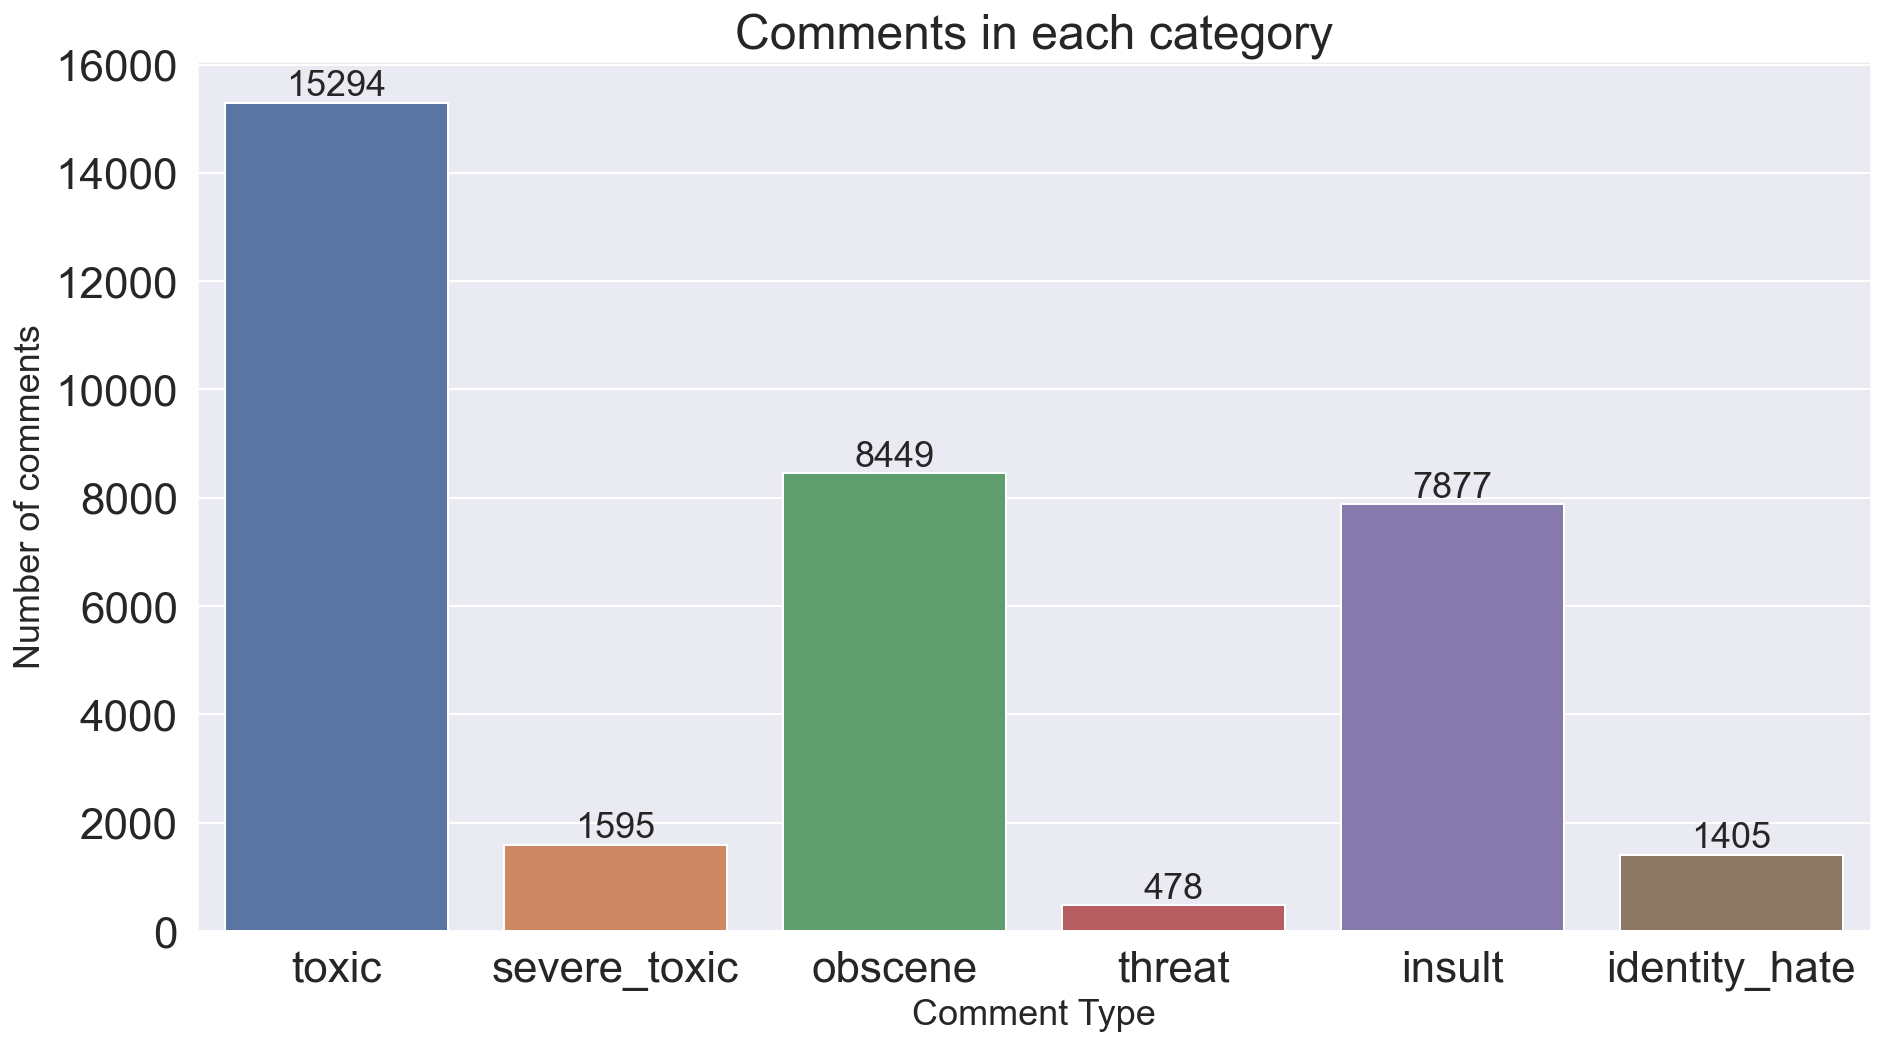

[15294  1595  8449   478  7877  1405]


In [4]:
#toxic_commentText = train.iloc[:,1]
label_toxic = train.iloc[:,2]
label_severe = train.iloc[:,3]
label_obscene = train.iloc[:,4]
label_threat = train.iloc[:,5]
label_insult = train.iloc[:,6]
label_identityHate = train.iloc[:,7]
#toxic_labels = train.iloc[:,2:8]

categories = list(train.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize = (15,8))

ax = sns.barplot( x = categories[2:], y = train.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize = 24)
plt.ylabel('Number of comments', fontsize = 18)
plt.xlabel('Comment Type', fontsize = 18)

rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label,
           ha = 'center', va = 'bottom', fontsize = 18)
    
plt.show()

print(train.iloc[:,2:].sum().values)

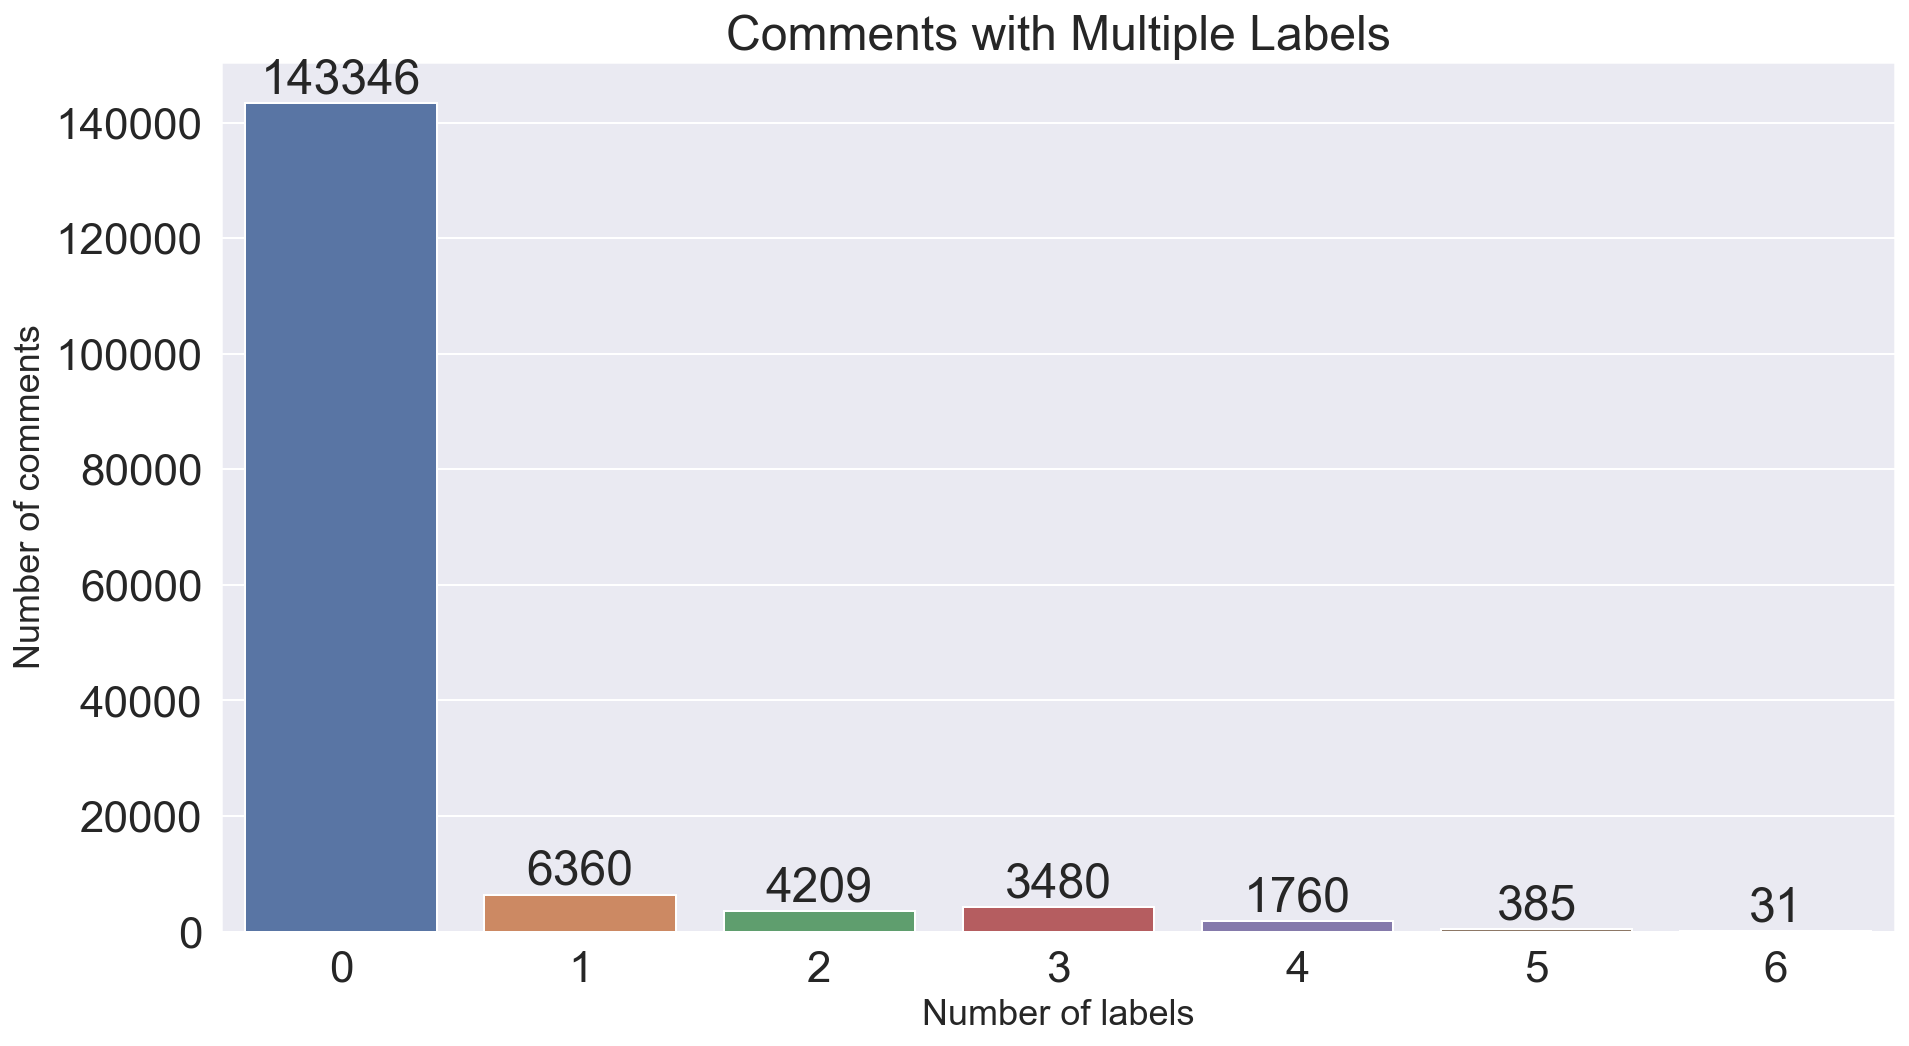

In [5]:
rowSums = train.iloc[:,2:].sum(axis = 1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]

sns.set(font_scale = 2)
plt.figure(figsize = (15,8))

ax = sns.barplot(x = multiLabel_counts.index, y = multiLabel_counts.values)

plt.title("Comments with Multiple Labels")
plt.ylabel('Number of comments', fontsize = 18)
plt.xlabel('Number of labels', fontsize = 18)

rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va = 'bottom')
    
plt.show()

In [ ]:
plt.figure(figsize = (40,25))
# whole
subset = train
text = subset.comment_text.values
cloud_whole = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))
plt.axis('off')
plt.title("Wordcloud of Entire Training Set", fontsize = 40)
plt.imshow(cloud_whole)

In [ ]:
plt.figure(figsize = (40,25))
# toxic
subset = train[train.toxic == True]
text = subset.comment_text.values
cloud_toxic = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))
plt.axis('off')
plt.title("Toxic Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_toxic)

In [ ]:
plt.figure(figsize = (40,25))

# severe toxic
subset = train[train.severe_toxic == True]
text = subset.comment_text.values
cloud_severe_toxic = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Severe Toxic Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_severe_toxic)

In [ ]:
plt.figure(figsize = (40,25))

# identity hate
subset = train[train.identity_hate == True]
text = subset.comment_text.values
cloud_identity_hate = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Identity Hate Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_identity_hate)

In [ ]:
plt.figure(figsize = (40,25))

# threat
subset = train[train.threat == True]
text = subset.comment_text.values
cloud_threat = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Threat Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_threat)

In [ ]:
plt.figure(figsize = (40,25))

# obscene
subset = train[train.obscene == True]
text = subset.comment_text.values
cloud_obscene = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Obscene Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_obscene)

In [ ]:
plt.figure(figsize = (40,25))

# insult
subset = train[train.insult == True]
text = subset.comment_text.values
cloud_insult = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Insult Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_insult)

# Data Cleaning

In [13]:
train = pd.read_csv("train.csv")


test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
comments_test = pd.DataFrame(test)
comments_test['toxic'] = pd.Series(test_labels['toxic'])
comments_test['severe_toxic'] = pd.Series(test_labels['severe_toxic'])
comments_test['obscene'] = pd.Series(test_labels['obscene'])
comments_test['threat'] = pd.Series(test_labels['threat'])
comments_test['insult'] = pd.Series(test_labels['insult'])
comments_test['identity_hate'] = pd.Series(test_labels['identity_hate'])
# Removing untested rows
comments_test = comments_test[comments_test.toxic != -1]


comment_column = 'comment_text'
cleaned_test = pd.DataFrame(cleaner(comments_test, comment_column))
cleaned_training = pd.DataFrame(cleaner(train, comment_column))

/var/folders/zj/t6kd4pzs42xfjqpmsg7y_cj00000gn/T/ipykernel_41387/2530876653.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  current_df[comments_column_name] = current_df[comments_column_name].str.replace('[^\w\s]','')


In [14]:
cleaned_test.index = np.arange(len(cleaned_test))

# Data Visualization Post-Cleaning

In [ ]:
plt.figure(figsize = (40,25))
# whole
subset = cleaned_training
text = subset.comment_text.values
cloud_whole = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))
plt.axis('off')
plt.title("Wordcloud of Entire Training Set", fontsize = 40)
plt.imshow(cloud_whole)

In [ ]:
plt.figure(figsize = (40,25))
# toxic
subset = cleaned_training[cleaned_training.toxic == True]
text = subset.comment_text.values
cloud_toxic = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))
plt.axis('off')
plt.title("Toxic Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_toxic)

In [ ]:
plt.figure(figsize = (40,25))

# severe toxic
subset = cleaned_training[cleaned_training.severe_toxic == True]
text = subset.comment_text.values
cloud_severe_toxic = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Severe Toxic Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_severe_toxic)

In [ ]:
plt.figure(figsize = (40,25))

# identity hate
subset = cleaned_training[cleaned_training.identity_hate == True]
text = subset.comment_text.values
cloud_identity_hate = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Identity Hate Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_identity_hate)

In [ ]:
plt.figure(figsize = (40,25))

# threat
subset = cleaned_training[cleaned_training.threat == True]
text = subset.comment_text.values
cloud_threat = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Threat Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_threat)

In [ ]:
plt.figure(figsize = (40,25))

# obscene
subset = cleaned_training[cleaned_training.obscene == True]
text = subset.comment_text.values
cloud_obscene = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Obscene Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_obscene)

In [ ]:
plt.figure(figsize = (40,25))

# insult
subset = cleaned_training[cleaned_training.insult == True]
text = subset.comment_text.values
cloud_insult = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        collocations = False,
                       width = 2500,
                       height = 1800
                       ).generate(" ".join(text))

plt.axis('off')
plt.title("Insult Comments Wordcloud", fontsize = 40)
plt.imshow(cloud_insult)

# Vectorization by TF-IDF

In [22]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(cleaned_training.comment_text) #sparse matrix (many zero entries)
print(X_train.shape) # rows are documents; columns are features (tokens/words)
print(X_train[1]) # for example, the value at index (0,129024) denotes the tfidf weighting of 129024 feature of document 0

(159571, 208855)
  (0, 190612)	0.16376829958539313
  (0, 6981)	0.33958980831715085
  (0, 1758)	0.24053828480322914
  (0, 100621)	0.23507738237902048
  (0, 7714)	0.41583722228100195
  (0, 178470)	0.1195991649311617
  (0, 169559)	0.2774048771261454
  (0, 158923)	0.1494204559861538
  (0, 46705)	0.28937646489199015
  (0, 29458)	0.24950914416211056
  (0, 116216)	0.2420689894890944
  (0, 53603)	0.4738405481262905
  (0, 94266)	0.1301368272428198
  (0, 173143)	0.1103755579332179


# Logistic Regression: Classifier Chain

In [23]:

X_train = vectorizer.fit_transform(cleaned_training.comment_text)
Y_train = cleaned_training.to_numpy()[:,2:] #convert set of just the 'toxic' label indicators to numpy array
Y_train = Y_train.astype(int) # change dtype into int

X_test = vectorizer.transform(cleaned_test.comment_text)
Y_test = cleaned_test.to_numpy()[:,2:]

base_lr = LogisticRegression(solver='liblinear', random_state=0)
chain = ClassifierChain(base_lr, order='random', random_state=0)
predictions = chain.fit(X_train, Y_train).predict(X_test)

In [24]:
np.unique(predictions[:,0])
np.unique(Y_test[:,0].astype(int))

Y_test = Y_test.astype(int)
print(precision_recall_fscore_support(predictions[:,0],Y_test[:,0]))

print(confusion_matrix(predictions[:,5], Y_test[:,5]))

(array([0.97199765, 0.62545156]), array([0.96104051, 0.7014733 ]), array([0.96648803, 0.66128472]), array([58548,  5430]))
[[63173   522]
 [   93   190]]


In [25]:
for i in range(6):
    print('Confusion matrix for label', i+1)
    print(confusion_matrix(predictions[:,i], Y_test[:,i]))
#     print(' ')
#     print('Precision and Recall:')
#     print(precision_recall_fscore_support(fit[:,i], Y_test[:,i]))
#     print(' ')

Confusion matrix for label 1
[[56267  2281]
 [ 1621  3809]]
Confusion matrix for label 2
[[63462   262]
 [  149   105]]
Confusion matrix for label 3
[[59500  1385]
 [  787  2306]]
Confusion matrix for label 4
[[63729   177]
 [   38    34]]
Confusion matrix for label 5
[[59422  1506]
 [ 1129  1921]]
Confusion matrix for label 6
[[63173   522]
 [   93   190]]


In [26]:
label_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']
print(classification_report(Y_test, predictions,target_names=label_names))

               precision    recall  f1-score   support

        Toxic       0.70      0.63      0.66      6090
 Severe Toxic       0.41      0.29      0.34       367
      Obscene       0.75      0.62      0.68      3691
       Threat       0.47      0.16      0.24       211
       Insult       0.63      0.56      0.59      3427
Identity Hate       0.67      0.27      0.38       712

    micro avg       0.69      0.58      0.63     14498
    macro avg       0.61      0.42      0.48     14498
 weighted avg       0.68      0.58      0.62     14498
  samples avg       0.05      0.05      0.05     14498



/Users/pinklotus/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pinklotus/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# OneVsRest Classifier

In [27]:
#This estimator uses the binary relevance method to perform multilabel classification, 
#which involves training one binary classifier independently for each label.

#https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
#http://scikit.ml/api/skmultilearn.problem_transform.br.html

clf = OneVsRestClassifier(base_lr).fit(X_train, Y_train)
ovr_preds = clf.predict(X_test)

print(classification_report(Y_test, ovr_preds))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      6090
           1       0.39      0.34      0.36       367
           2       0.74      0.64      0.69      3691
           3       0.47      0.17      0.24       211
           4       0.71      0.53      0.61      3427
           5       0.67      0.27      0.38       712

   micro avg       0.67      0.61      0.64     14498
   macro avg       0.60      0.44      0.49     14498
weighted avg       0.68      0.61      0.64     14498
 samples avg       0.06      0.06      0.06     14498



/Users/pinklotus/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pinklotus/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
hamming_loss(Y_test, predictions)

#In multilabel classification, the Hamming loss is different from the subset zero-one loss. 
#The zero-one loss considers the entire set of labels for a given sample incorrect if it does not 
#entirely match the true set of labels.
#Hamming loss is more forgiving in that it penalizes only the individual labels

#https://en.wikipedia.org/wiki/Hamming_distance

0.025920368459991454

In [29]:
hamming_loss(Y_test, ovr_preds)

0.02578751028999552

# ML-KNN

In [30]:
classifier = MLkNN(k=12)
mlknn_clf = classifier.fit(X = X_train, y = Y_train)

/Users/pinklotus/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [31]:
mlknn_preds = mlknn_clf.predict(X_test)
mlknn_preds_d = np.asarray(mlknn_preds.todense())
hamming_loss(Y_test, mlknn_preds_d)

0.035113632811278876

# ROC AUC Score

In [32]:
Y_score = chain.predict_proba(X_test)
roc_auc_score(Y_test, chain.predict_proba(X_test))

0.9686216581457648

In [33]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


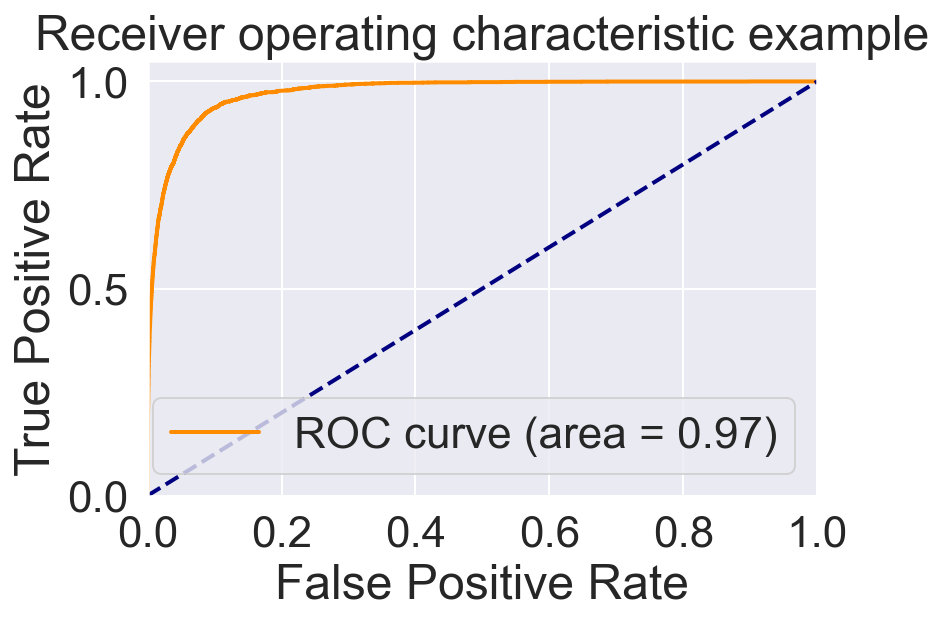

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

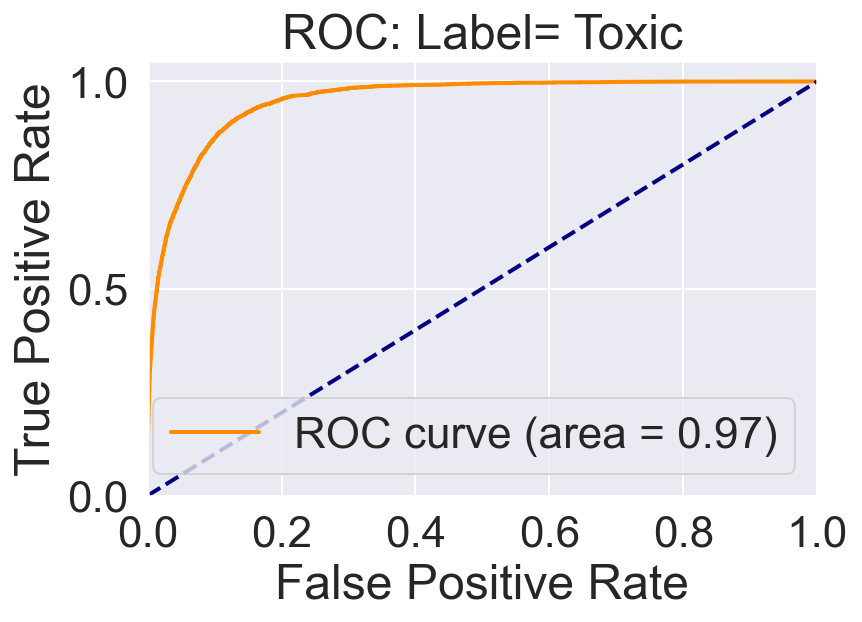

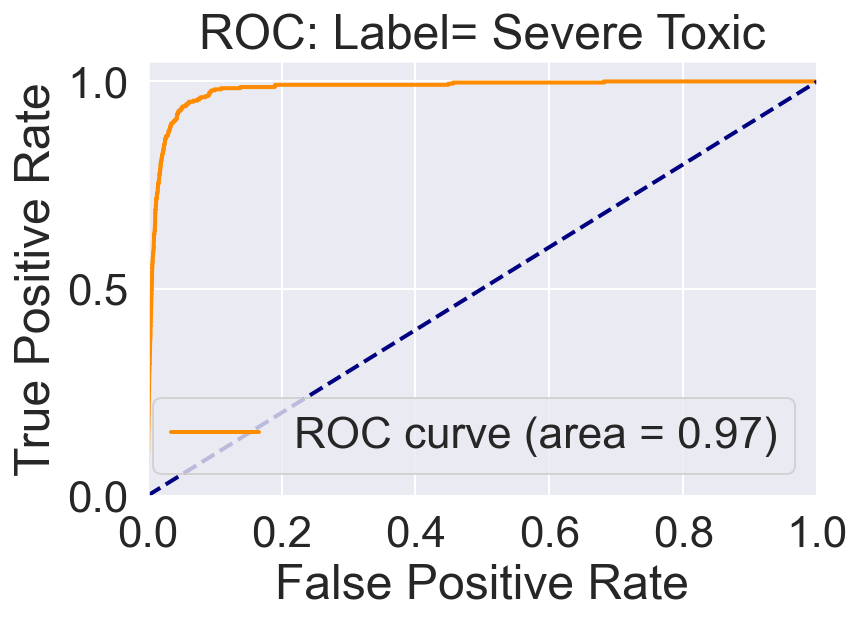

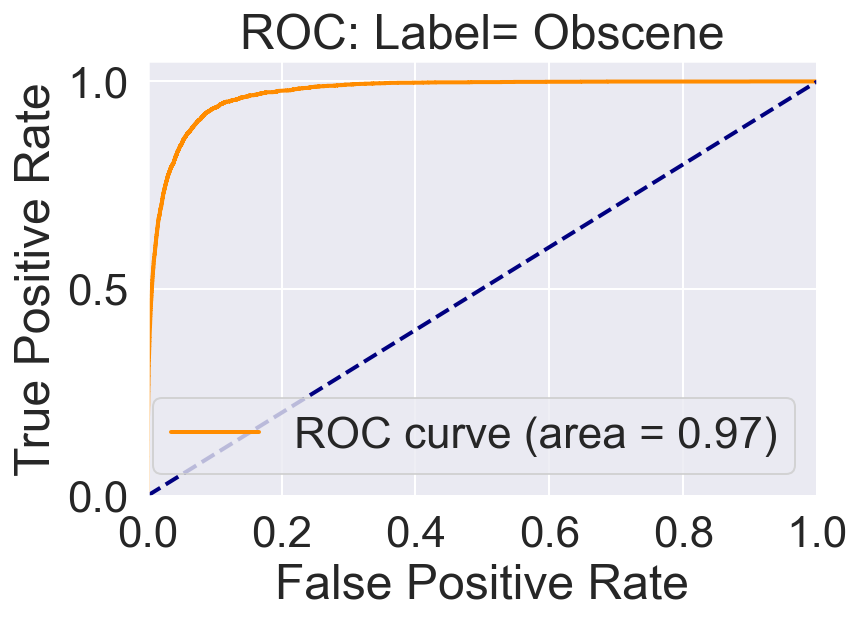

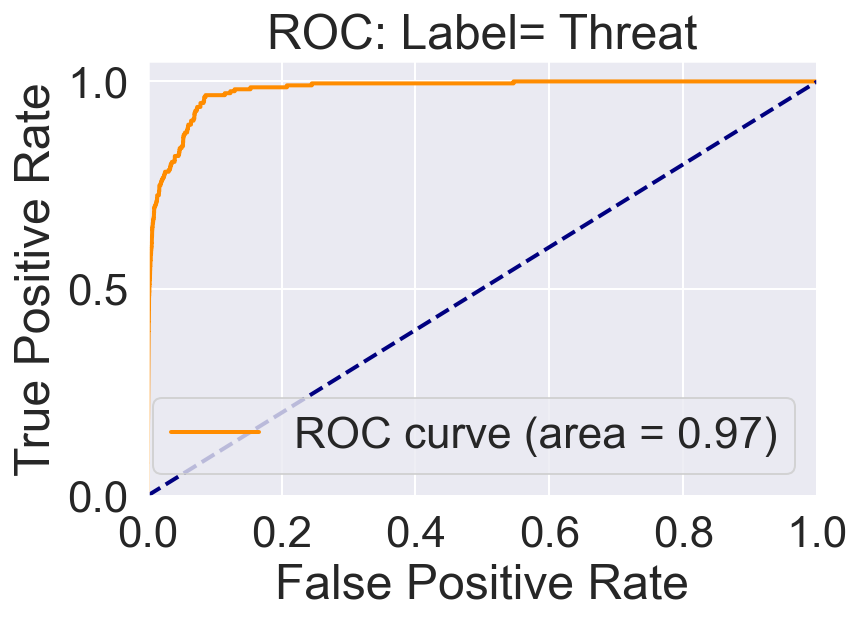

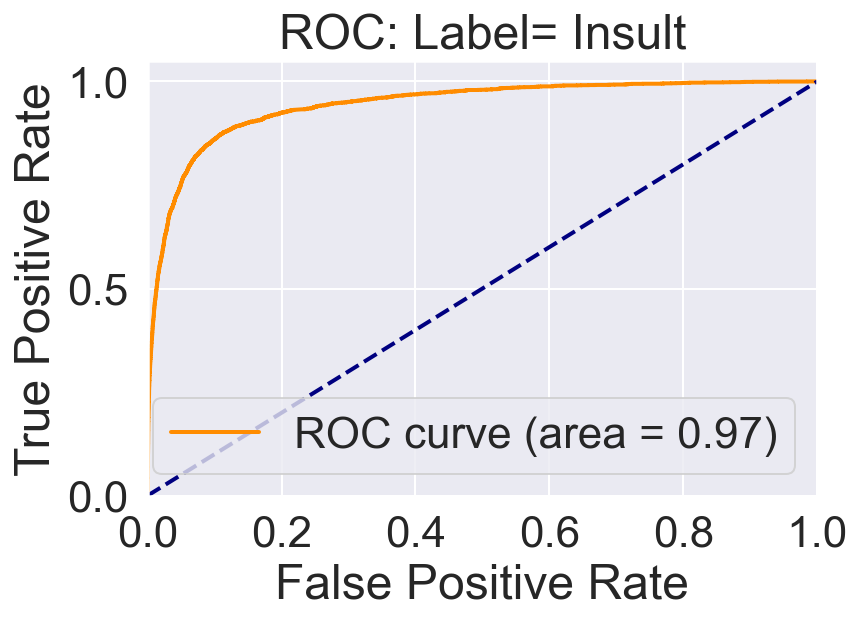

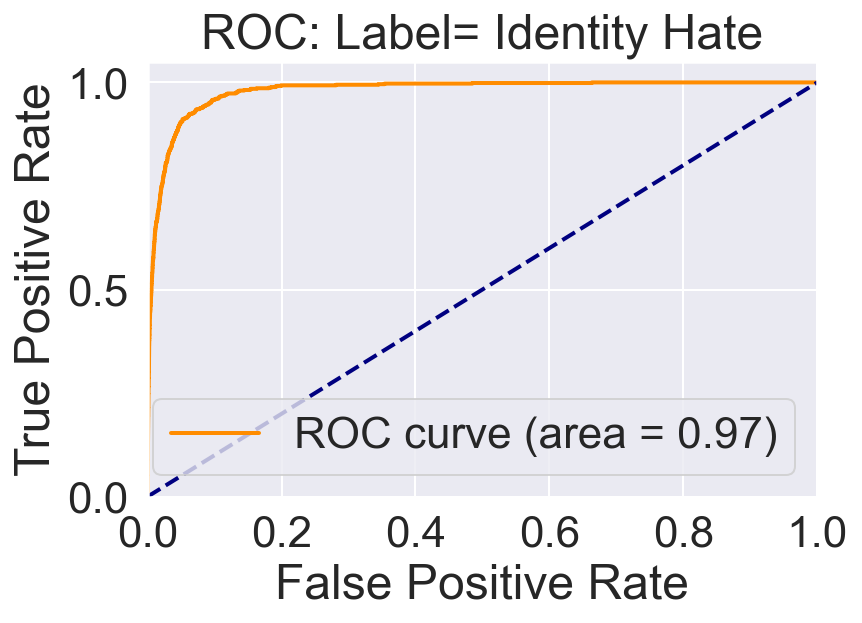

In [35]:
label_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']

for i in range(6):
    plt.figure()
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[2],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC: Label= {}'.format(label_names[i]))
    plt.legend(loc="lower right")
    plt.show()

# Word2Vec Vectorization

In [36]:
cleaned_training["comment_text"] = cleaned_training["comment_text"].str.split() # split texts into word
phrases = gensim.models.phrases.Phrases(cleaned_training['comment_text'].tolist()) # USE COMMON PHRASES AS 1 ENTITY
phraser = gensim.models.phrases.Phraser(phrases)
train_phrased = phraser[cleaned_training['comment_text'].tolist()]

In [37]:
w2v = gensim.models.word2vec.Word2Vec(sentences=train_phrased)
w2v.save('w2v_v1')

In [38]:
w2v.wv["shit"]

array([-0.45352733, -0.9556309 , -0.30917785, -0.81444156,  0.6399686 ,
       -1.6895546 ,  1.0323638 ,  2.5888388 ,  0.28622758,  1.0018895 ,
       -1.801506  , -0.43471193, -0.09766165,  1.3787007 ,  1.4531351 ,
        0.19699514, -1.3913738 ,  1.1914558 ,  0.62203884,  0.8129266 ,
        0.15359075, -0.07305624, -1.2448182 , -1.0995473 , -1.0418593 ,
       -1.140162  ,  0.6971041 , -1.5859696 , -0.1503398 , -1.5964485 ,
        1.9002528 ,  0.0691877 , -0.7196474 ,  0.56270766, -0.85807234,
        1.5059181 ,  3.172099  ,  1.0328546 ,  0.8539401 , -0.5784412 ,
        1.9586371 , -0.29842955,  0.89498305,  0.7653754 ,  0.08166376,
       -1.2620698 , -0.3029485 , -1.4171457 ,  2.371678  , -0.8960687 ,
        2.245806  ,  0.45715532, -0.4481433 , -0.5065649 ,  1.018906  ,
        0.10806796,  0.51911306,  0.4857195 ,  0.86442244,  0.95541054,
        0.95978373, -0.43950278,  0.12888154, -0.70234656, -0.3122326 ,
        0.18746705,  0.8186714 , -0.9983724 , -0.48149246, -0.78

In [39]:
w2v.wv.similarity('shit','bullshit')

0.8154448

In [40]:
# repeat for test data
phrases_test = gensim.models.phrases.Phrases(cleaned_test['comment_text'].tolist()) # USE COMMON PHRASES AS 1 ENTITY
phraser_test = gensim.models.phrases.Phraser(phrases_test)
test_phrased = phraser_test[cleaned_test['comment_text'].tolist()]

In [41]:
training_vecs, missing, missing_texts = embeddings(cleaned_training["comment_text"], 100, w2v)
train_labels = cleaned_training[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_numpy()

In [42]:
train_vectors = training_vecs
mean_auc, lr = training_model(cleaned_training["comment_text"], 100, w2v)
print(mean_auc)

0.5817696732916708


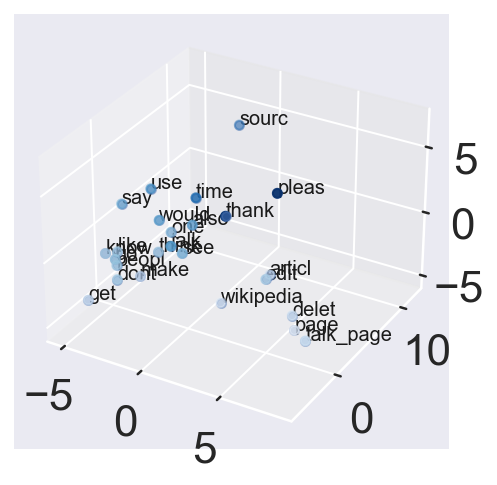

In [43]:
vectors = w2v.wv
pca = PCA(n_components=3)
new_vecs = [vectors[i] for i in range(len(vectors))]

fig = plt.figure()
#train the model 
graph_vecs = new_vecs[:25]
result = pca.fit_transform(graph_vecs)
#plot a scatter plot
ax = fig.add_subplot(projection='3d')

ax.scatter3D(result[:, 0], result[:, 1], result[:,2], c=result[:,2], cmap='Blues')

#add annotations of the words to the data points
words = list(w2v.wv.index_to_key[:25])
#for i, word in enumerate(words):
    #plt.annotate(word, size=10, xy=(result[i, 0], result[i, 1], result[i,2]))
    
for i in range(len(words)): #plot each point + it's index as text above
    ax.scatter(result[i,0],result[i,1],result[i,2],color='b', alpha=0.5) 
    ax.text(result[i,0],result[i,1],result[i,2],'%s' % (words[i]), size=10, zorder=1,  
    color='k') # label each word

In [44]:
testing_vecs, missing_test, missing_text_test = embeddings(cleaned_test["comment_text"], 100, w2v)
y_preds = np.transpose(np.array(lr.predict_proba(testing_vecs))[:,:,1])
df_test = pd.DataFrame()
df_test["comment_text"] = cleaned_test["comment_text"]
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = y_preds # add probs to df

In [45]:
df_test

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,thank understand think high would revert witho...,0.500022,0.500069,0.500029,0.500073,0.500025,0.500021
1,dear god site horribl,0.500079,0.500267,0.500112,0.500288,0.500092,0.500092
2,somebodi invari tri add religion realli mean w...,0.500027,0.500105,0.500044,0.500101,0.500035,0.500038
3,say right type type institut need case three l...,0.500046,0.500176,0.500074,0.500166,0.500058,0.500062
4,ad new product list make sure relev ad new pro...,0.500093,0.500356,0.500149,0.500357,0.500116,0.500126
...,...,...,...,...,...,...,...
63973,jerom see never got around im surpris look exa...,0.977020,0.999999,0.997545,0.999998,0.991176,0.993118
63974,lucki bastard httpwikimediafoundationorgwikipr...,0.999289,1.000000,0.999991,1.000000,0.999891,0.999933
63975,shame want speak gay romanian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
63976,mel gibson nazi bitch make shitti movi much bu...,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
y_true = np.array(cleaned_test.iloc[:,2:])
aucs = []
for col in range(y_true.shape[1]):
        aucs.append(roc_auc_score(y_true[:,col],y_preds[:,col]))

mean_auc = np.mean(aucs)
mean_auc

0.5973099314390772

In [47]:
label_names = ['toxic', 'severe-toxic', 'obscene','threat','insult','identity_hate']
pred_prob = pd.DataFrame(np.transpose(np.array(lr.predict_proba(testing_vecs))[:,:,1]))
pred_prob.columns = label_names
label_prob = np.array(pred_prob.applymap(lambda x: 1 if x>0.5 else 0)) # apply threshold to label

In [48]:
precision_recall_fscore_support(y_true,label_prob, zero_division=0)

(array([0.09518897, 0.00573635, 0.05769171, 0.00329801, 0.05356529,
        0.01112883]),
 array([1., 1., 1., 1., 1., 1.]),
 array([0.17383114, 0.01140726, 0.10908983, 0.00657434, 0.10168385,
        0.02201268]),
 array([6090,  367, 3691,  211, 3427,  712]))

In [49]:
print(classification_report(y_true, label_prob, zero_division=0, target_names=label_names))

               precision    recall  f1-score   support

        toxic       0.10      1.00      0.17      6090
 severe-toxic       0.01      1.00      0.01       367
      obscene       0.06      1.00      0.11      3691
       threat       0.00      1.00      0.01       211
       insult       0.05      1.00      0.10      3427
identity_hate       0.01      1.00      0.02       712

    micro avg       0.04      1.00      0.07     14498
    macro avg       0.04      1.00      0.07     14498
 weighted avg       0.07      1.00      0.13     14498
  samples avg       0.04      0.10      0.05     14498



In [50]:
precisions = []; recalls = []; thresholds = []
for col in range(y_true.shape[1]): 
    precision, recall, threshold = precision_recall_curve(y_true[:,col], y_preds[:,col]) 
    precisions.append(precision) 
    recalls.append(recall) 
    thresholds.append(threshold)

In [51]:
summary_precision = np.transpose(pd.DataFrame([np.mean(row[:-1]) for row in precisions]))
summary_precision.columns = ['toxic', 'severe-toxic', 'obscene','threat','insult','identity_hate']
summary_precision # for each label 

,toxic,severe-toxic,obscene,threat,insult,identity_hate
0,0.131738,0.005782,0.076953,0.003913,0.072638,0.014581


In [52]:
summary_recall = np.transpose(pd.DataFrame([np.mean(row[:-1]) for row in recalls]))
summary_recall.columns = ['toxic', 'severe-toxic', 'obscene','threat','insult','identity_hate']
summary_recall # for each label

,toxic,severe-toxic,obscene,threat,insult,identity_hate
0,0.666184,0.659803,0.698976,0.757522,0.679742,0.664722


In [53]:
log_loss(y_true, y_preds)

0.40914927181190064

In [54]:
balanced_scores = []
for col in range(y_true.shape[1]):
        balanced_scores.append(balanced_accuracy_score(y_true[:,col],label_prob[:,col])) #balanced scores of each label
        
np.mean(balanced_scores) # take mean of each label

0.5